In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torchvision.models.detection import ssd300_vgg16
from torch.optim import SGD
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
main_dir = "/kaggle/input/aiunict2024-challenge-2/"
data = "/kaggle/input/aiunict2024-challenge-2/train"
test_dir = "/kaggle/input/aiunict2024-challenge-2/test"
output_csv = "/kaggle/working/submission.csv"

In [4]:
#Custom Dataset
class Datax(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img_path = os.path.join(self.root_dir, img_id)
        image = io.imread(img_path) #returns img as numpy array

        # Bounding box coordinates
        x1 = self.annotations.iloc[index, 1]
        y1 = self.annotations.iloc[index, 2]
        x2 = self.annotations.iloc[index, 3]
        y2 = self.annotations.iloc[index, 4]
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32)  # Wrap in a list to add batch dimension

        # Class label
        label = int(self.annotations.iloc[index, 5])
        labels = torch.tensor([label], dtype=torch.int64)  # Wrap in a list to add batch dimension

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        # Target is a dictionary 
        target = {"boxes": boxes, "labels": labels}

        return image, target


In [5]:
#Collate function
def collate_fn(batch):
    images, targets = zip(*batch)  
    images = list(images)
    targets = list(targets)
    return images, targets


In [6]:
# Albumentations transforms for the training set
train_transform = A.Compose([
    A.RandomResizedCrop(height=300, width=300, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [7]:
#Creating instance
dataex = Datax(csv_file='/kaggle/input/aiunict2024-challenge-2/train.csv', 
               root_dir=data, 
               transform=train_transform)


In [8]:
# Validation data transformations
val_transform = A.Compose([
    A.Resize(300, 300),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [9]:
# Update Datax class for validation set
val_dataex = Datax(csv_file='/kaggle/input/aiunict2024-challenge-2/train.csv', 
                   root_dir=data, 
                   transform=val_transform)


In [10]:
# train test split new
labels = [item[1]['labels'].item() for item in dataex]
train_indices, val_indices = train_test_split(range(len(dataex)), test_size=0.3, random_state=42, stratify=labels)

train_set = Subset(dataex, train_indices)
val_set = Subset(val_dataex, val_indices)

train_loader = DataLoader(dataset=train_set, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset=val_set, batch_size=8, shuffle=False, collate_fn=collate_fn)


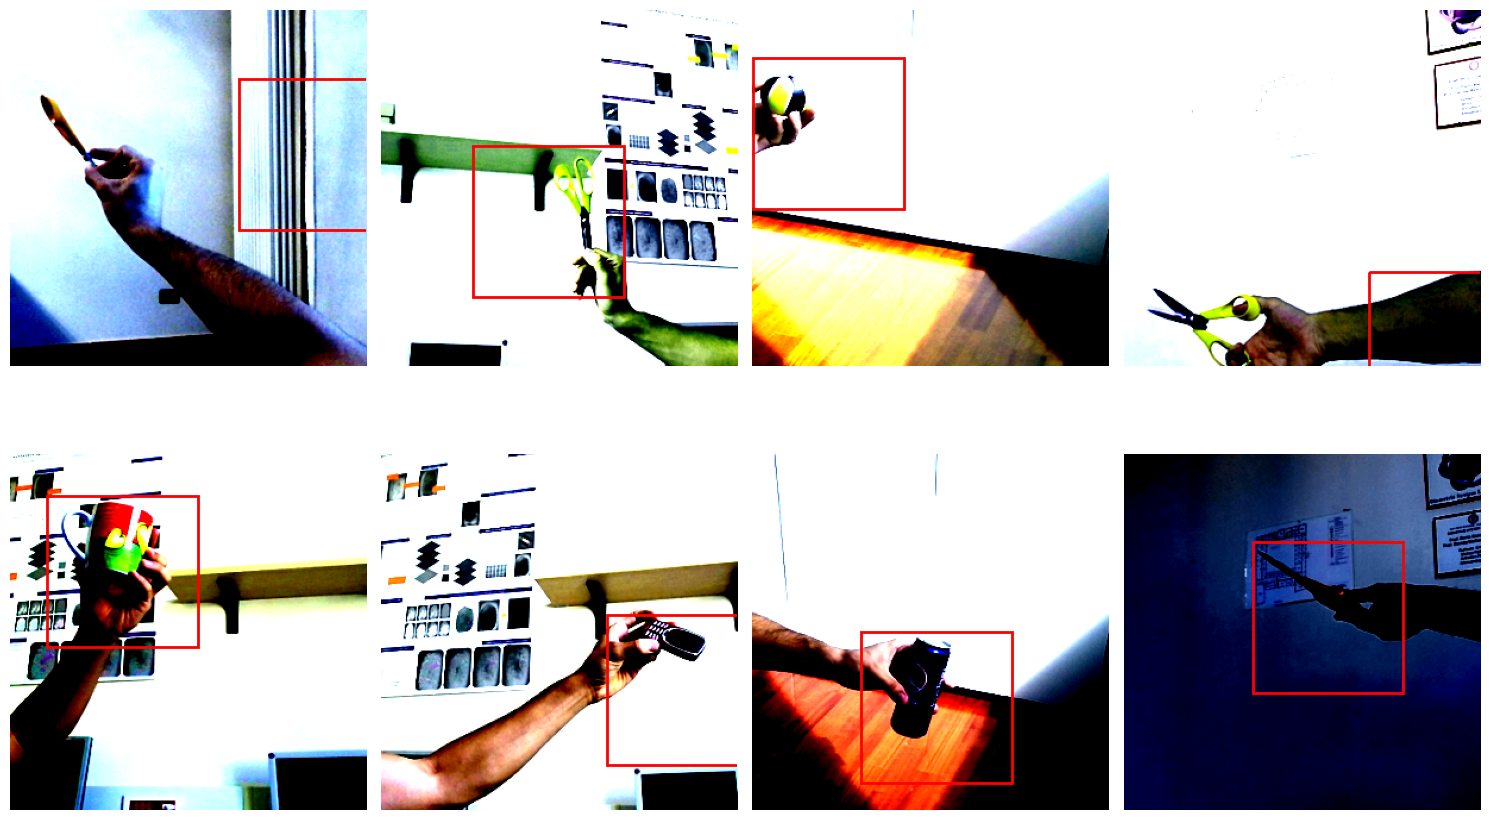

In [11]:
#Plotting transformed images with bboxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_images_with_bboxes(images, targets, num_images=8):
    fig, axs = plt.subplots(2, 4, figsize=(15, 10))
    
    for i in range(num_images):
        ax = axs[i // 4, i % 4]
        img = images[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C) for plotting
        ax.imshow(img)
        
        for box in targets[i]["boxes"]:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        ax.axis('off')

    plt.tight_layout()
    plt.show()

images, targets = next(iter(train_loader))
plot_images_with_bboxes(images, targets)


In [12]:
#Defining model
model = ssd300_vgg16(pretrained=True)
model.to(device)
num_classes = 9  # Including background
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 186MB/s]


In [13]:
#Defining val model
def validate_model(model, val_loader, device):
    model.train()  # Set the model to training mode for loss calculation
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validation"):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass to calculate the validation loss
            loss_dict = model(images, targets)
            
            # Calculate the total validation loss
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    return val_loss / len(val_loader)


In [14]:
# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training phase
    for images, targets in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Calculate the total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}')

    # Validation phase
    avg_val_loss = validate_model(model, val_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

# Save the model after training
torch.save(model, "/kaggle/working/modelnew.pth")


Training Epoch 1/10: 100%|██████████| 140/140 [00:53<00:00,  2.61it/s]


Epoch [1/10], Training Loss: 4.8566


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.86it/s]


Epoch [1/10], Validation Loss: 3.0936


Training Epoch 2/10: 100%|██████████| 140/140 [00:53<00:00,  2.62it/s]


Epoch [2/10], Training Loss: 3.5303


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Epoch [2/10], Validation Loss: 2.6981


Training Epoch 3/10: 100%|██████████| 140/140 [00:53<00:00,  2.63it/s]


Epoch [3/10], Training Loss: 3.0557


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.70it/s]


Epoch [3/10], Validation Loss: 2.7181


Training Epoch 4/10: 100%|██████████| 140/140 [00:53<00:00,  2.61it/s]


Epoch [4/10], Training Loss: 2.8647


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Epoch [4/10], Validation Loss: 2.3192


Training Epoch 5/10: 100%|██████████| 140/140 [00:53<00:00,  2.63it/s]


Epoch [5/10], Training Loss: 2.6599


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Epoch [5/10], Validation Loss: 2.0271


Training Epoch 6/10: 100%|██████████| 140/140 [00:53<00:00,  2.63it/s]


Epoch [6/10], Training Loss: 2.4228


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Epoch [6/10], Validation Loss: 1.8835


Training Epoch 7/10: 100%|██████████| 140/140 [00:53<00:00,  2.63it/s]


Epoch [7/10], Training Loss: 2.2238


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.75it/s]


Epoch [7/10], Validation Loss: 1.7589


Training Epoch 8/10: 100%|██████████| 140/140 [00:52<00:00,  2.64it/s]


Epoch [8/10], Training Loss: 2.0923


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.73it/s]


Epoch [8/10], Validation Loss: 1.5755


Training Epoch 9/10: 100%|██████████| 140/140 [00:53<00:00,  2.64it/s]


Epoch [9/10], Training Loss: 2.0698


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.74it/s]


Epoch [9/10], Validation Loss: 1.7156


Training Epoch 10/10: 100%|██████████| 140/140 [00:53<00:00,  2.64it/s]


Epoch [10/10], Training Loss: 2.0678


Validation: 100%|██████████| 60/60 [00:12<00:00,  4.72it/s]


Epoch [10/10], Validation Loss: 1.6927


In [15]:
# Test Dataset
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        
        return image, img_path

In [16]:
# Test DataLoader
test_dataset = TestDataset(
    test_dir=test_dir,
    transform=A.Compose([
        A.Resize(300, 300), 
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)


In [17]:
# Inference Function
def infer_on_test_set(model, test_loader, device):
    image_ids = []
    image_classes = []

    model.eval()
    with torch.no_grad():
        for images, image_paths in test_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            for prediction, img_path in zip(predictions, image_paths):
                pred_label = prediction['labels'].cpu().numpy()[0]

                image_ids.append(os.path.basename(img_path))
                image_classes.append(pred_label)

    return image_ids, image_classes



In [18]:
# Perform inference and save to CSV
image_ids, image_classes = infer_on_test_set(model, test_loader, device)

# Create DataFrame
df = pd.DataFrame({
    'image': image_ids,
    'class': image_classes
})


df_sorted = df.sort_values(by='image', ascending=True)
df_sorted.to_csv(output_csv, index=False)
